In [1]:
import requests

In [2]:
import pandas as pd

In [3]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np

In [5]:
import statsmodels
import scipy
from scipy.stats import ks_1samp, gaussian_kde, norm
from statsmodels.distributions.empirical_distribution import ECDF

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
from datetime import datetime

In [8]:
def KS_test(sample1, dist = scipy.stats.norm, ax=None, labels=['sample1', 'Norm']):
    """
    Tests the hypothesis that two samples are generated from the same distribution.
    Plots the empirical cdfs and kernel density estimator of pdfs.
    """
    ecdf1 = ECDF(sample1)

    kde1 = gaussian_kde(sample1)

    mean_ = sample1.mean()
    std_ = sample1.std()

    x = np.linspace(np.percentile(sample1, 1),
                    np.percentile(sample1, 99),
                    1000)

    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].set_title("Empirical cdfs")
    ax[0].plot(x, ecdf1(x), 'b', label=labels[0])
    ax[0].plot(x, dist.cdf(x, mean_, std_ ), 'g', label=labels[1])
    ax[0].grid('on')
    ax[0].legend()

    ax[1].set_title("KDE of pdfs")
    ax[1].plot(x, kde1(x), 'b', label=labels[0])
    ax[1].plot(x, dist.pdf(x, mean_, std_ ), 'g', label=labels[1])
    ax[1].grid('on')
    ax[1].legend()
    
    return ks_1samp(sample1, dist.cdf)

#UNI Prices

In [9]:
request_url = "https://api.coingecko.com/api/v3/coins/uniswap/market_chart?vs_currency=usd&days=max&interval=daily"
data = requests.get(request_url).json()


In [10]:
items = []
for (p, mc, tv) in zip(data['prices'], data['market_caps'], data['total_volumes']):
    item = [p[0], p[1], mc[1], tv[1]]
    items.append(item)

df = pd.DataFrame(items)

In [11]:
df.columns = ['ts', 'prices', 'market_caps', 'total_volumes']
df['date'] = df.ts.apply(lambda x: datetime.utcfromtimestamp(x//1000))
df.drop(['ts'], axis = 1, inplace = True)
df.set_index('date', inplace = True)

In [12]:
df

,prices,market_caps,total_volumes
date,,,
2020-09-17 00:00:00,3.443832,2.199132e+08,1.802085e+09
2020-09-18 00:00:00,3.443832,2.199132e+08,1.802085e+09
2020-09-19 00:00:00,7.097694,7.328221e+08,5.688408e+09
2020-09-20 00:00:00,5.702061,6.472084e+08,2.050756e+09
2020-09-21 00:00:00,5.256579,6.324213e+08,1.316669e+09
...,...,...,...
2022-11-01 00:00:00,6.973267,5.245240e+09,1.557036e+08
2022-11-02 00:00:00,7.126841,5.375259e+09,2.222424e+08
2022-11-03 00:00:00,7.097752,5.351315e+09,2.499125e+08


In [13]:
df.describe()

,prices,market_caps,total_volumes
count,780.000000,7.800000e+02,7.800000e+02
mean,14.823218,7.106110e+09,4.754305e+08
std,10.151380,5.432143e+09,5.270792e+08
min,1.928177,2.199132e+08,5.344331e+07
25%,6.063860,2.784909e+09,1.654545e+08
50%,10.677175,5.056681e+09,2.775730e+08
75%,23.409133,1.161931e+10,5.468098e+08
max,42.884097,2.253105e+10,5.688408e+09


In [14]:
df[df.index > '2022-01-01'].describe()

,prices,market_caps,total_volumes
count,308.000000,3.080000e+02,3.080000e+02
mean,8.160353,4.087996e+09,1.770518e+08
std,3.023900,1.355242e+09,8.259367e+07
min,3.605529,1.635283e+09,5.344331e+07
25%,6.031222,3.022014e+09,1.194569e+08
50%,7.132973,4.139487e+09,1.565394e+08
75%,9.672703,4.834126e+09,2.145988e+08
max,18.438002,8.379921e+09,5.988561e+08


In [15]:

px.bar(df)

Цена на коин со временем снижается

Не смог найти разделение total_supply на cex/dex биржи на https://defillama.com и https://www.coingecko.com их нет но нашел обший обьем

Нарисуем cdf и pdf данных  и сравним с нормальным

KstestResult(statistic=0.9847866652795563, pvalue=0.0)

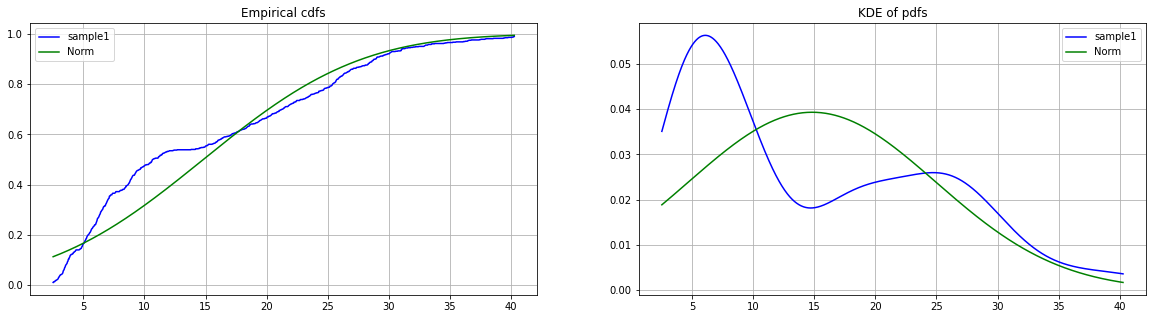

In [16]:
KS_test(df.prices.values, norm)

KstestResult(statistic=1.0, pvalue=0.0)

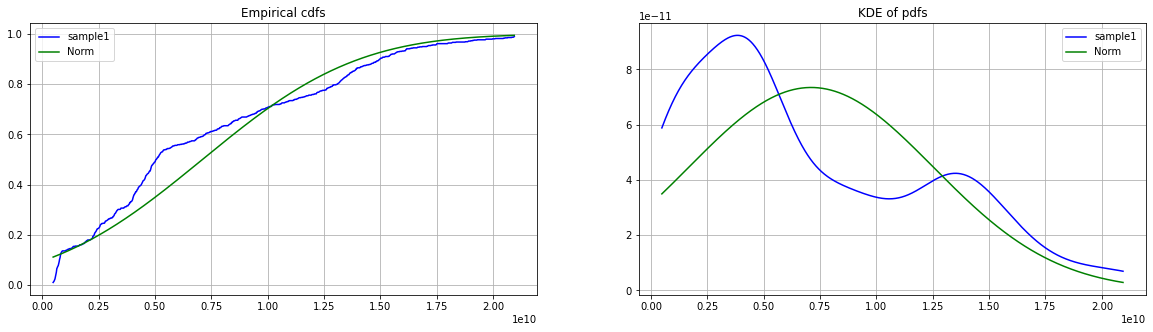

In [17]:
KS_test(df.market_caps.values, norm)

KstestResult(statistic=1.0, pvalue=0.0)

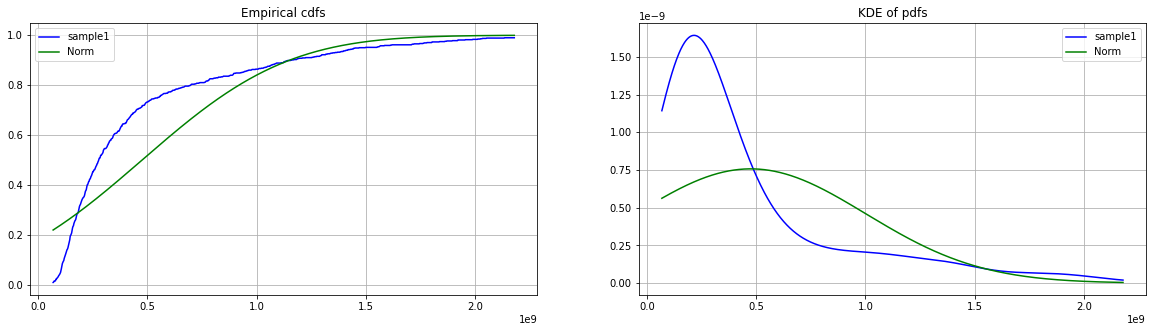

In [18]:
KS_test(df.total_volumes.values, norm)

ничего нормального нет :(

#UNI total supply

In [19]:
request_url = "https://api.coingecko.com/api/v3/coins/uniswap"
data = requests.get(request_url).json()

In [20]:
data['market_data']['total_supply']

1000000000.0

In [21]:
data['market_data']['max_supply']

1000000000.0

Тк total_supply == max_supply значит коиный не "сжигались" => total supply не менялся

#UNISWAP TVL

In [22]:
from datetime import datetime
tvls = requests.get('https://api.llama.fi/protocol/uniswap').json()['chainTvls']



TVL = None
for key in tvls.keys():
    tmp = pd.DataFrame(tvls[key]['tvl'])
    
    if TVL is None:
        TVL = tmp
        continue

    TVL = TVL.merge(tmp, on='date', suffixes=('', key), how='outer')
    
TVL['date'] = TVL.date.apply(lambda x: datetime.utcfromtimestamp(x))

In [23]:
TVL.set_index('date', inplace = True)

In [24]:
TVL

,totalLiquidityUSD,totalLiquidityUSDOptimism,totalLiquidityUSDPolygon,totalLiquidityUSDCelo,totalLiquidityUSDArbitrum
date,,,,,
2018-11-03,3.464389e+04,NaN,NaN,NaN,NaN
2018-11-04,4.126818e+04,NaN,NaN,NaN,NaN
2018-11-05,4.055178e+04,NaN,NaN,NaN,NaN
2018-11-06,4.309134e+04,NaN,NaN,NaN,NaN
2018-11-07,1.539794e+05,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-10-31,4.035889e+09,5.028660e+07,8.859798e+07,9.231935e+05,7.014237e+07
2022-11-01,4.006696e+09,4.964292e+07,8.898412e+07,1.064409e+06,7.107238e+07
2022-11-02,4.034659e+09,4.914678e+07,9.036235e+07,9.278947e+05,7.164081e+07


In [25]:
TVL.describe()

,totalLiquidityUSD,totalLiquidityUSDOptimism,totalLiquidityUSDPolygon,totalLiquidityUSDCelo,totalLiquidityUSDArbitrum
count,1.463000e+03,3.570000e+02,3.190000e+02,1.190000e+02,4.280000e+02
mean,3.102562e+09,4.123821e+07,7.468933e+07,1.090995e+06,6.091118e+07
std,3.253354e+09,1.013775e+07,2.216227e+07,2.311872e+05,1.572602e+07
min,3.464389e+04,9.627025e+06,1.656287e+03,2.772709e+04,1.757643e+06
25%,2.300657e+07,3.510581e+07,6.034663e+07,1.004314e+06,5.356993e+07
50%,2.098300e+09,4.358562e+07,7.474218e+07,1.056992e+06,6.138417e+07
75%,6.038311e+09,4.887389e+07,8.696470e+07,1.246837e+06,7.041578e+07
max,1.024044e+10,5.785002e+07,1.247007e+08,1.605677e+06,9.327423e+07


In [26]:
TVL[TVL.index > '2022-01-01'].describe()

,totalLiquidityUSD,totalLiquidityUSDOptimism,totalLiquidityUSDPolygon,totalLiquidityUSDCelo,totalLiquidityUSDArbitrum
count,3.070000e+02,3.070000e+02,3.070000e+02,1.190000e+02,3.070000e+02
mean,5.667994e+09,4.246132e+07,7.678723e+07,1.090995e+06,6.583804e+07
std,1.324856e+09,1.035357e+07,1.963931e+07,2.311872e+05,1.208561e+07
min,3.701764e+09,9.627025e+06,3.982466e+07,2.772709e+04,3.972767e+07
25%,4.362702e+09,3.595760e+07,6.266538e+07,1.004314e+06,5.754254e+07
50%,5.479681e+09,4.567051e+07,7.514667e+07,1.056992e+06,6.589099e+07
75%,6.849079e+09,4.938870e+07,8.743664e+07,1.246837e+06,7.273791e+07
max,8.890909e+09,5.785002e+07,1.247007e+08,1.605677e+06,9.327423e+07


In [27]:
px.bar(TVL[TVL.index > '2022-01-01'])

Нарисуем cdf и pdf данных  и сравним с нормальным

KstestResult(statistic=1.0, pvalue=0.0)

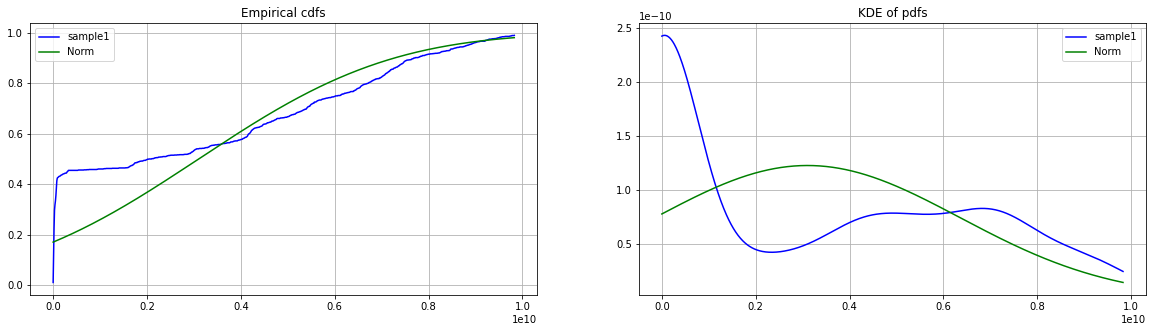

In [28]:
KS_test(TVL['totalLiquidityUSD'], norm)

KstestResult(statistic=1.0, pvalue=0.0)

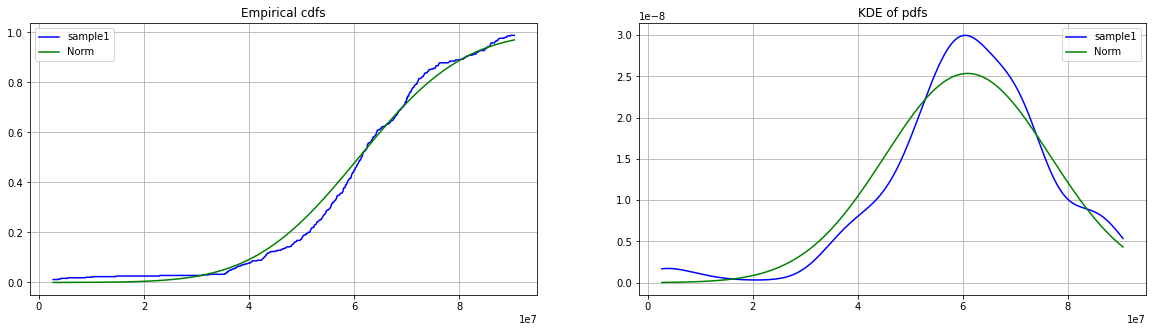

In [29]:
KS_test(TVL['totalLiquidityUSDArbitrum'].dropna(), norm)

#Uniswap_v1 TVL


In [30]:
from datetime import datetime
tvls = requests.get('https://api.llama.fi/protocol/uniswap-v1').json()['chainTvls']




TVL_v1 = None
for key in tvls.keys():
    tmp = pd.DataFrame(tvls[key]['tvl'])
    
    if TVL_v1 is None:
        TVL_v1 = tmp
        continue

    TVL_v1 = TVL_v1.merge(tmp, on='date', suffixes=('', key), how='outer')
    
TVL_v1['date'] = TVL_v1.date.apply(lambda x: datetime.utcfromtimestamp(x))

In [31]:
TVL_v1.set_index('date', inplace = True)

In [32]:
TVL_v1

,totalLiquidityUSD
date,
2018-11-03 00:00:00,3.464389e+04
2018-11-04 00:00:00,4.126818e+04
2018-11-05 00:00:00,4.055178e+04
2018-11-06 00:00:00,4.309134e+04
2018-11-07 00:00:00,1.539794e+05
...,...
2022-11-01 00:00:00,8.472041e+06
2022-11-02 00:00:00,8.384590e+06
2022-11-03 00:00:00,8.268977e+06


In [33]:
TVL_v1.describe()

,totalLiquidityUSD
count,1.464000e+03
mean,1.644002e+07
std,1.458959e+07
min,3.464389e+04
25%,8.202203e+06
50%,1.248578e+07
75%,1.752316e+07
max,8.302581e+07


In [34]:
TVL_v1[TVL_v1.index > '2022-01-01'].describe()

,totalLiquidityUSD
count,3.080000e+02
mean,1.021048e+07
std,2.207873e+06
min,7.289026e+06
25%,8.196270e+06
50%,9.126089e+06
75%,1.229597e+07
max,1.526869e+07


In [35]:
px.bar(TVL_v1[TVL_v1.index > '2022-01-01'])

KstestResult(statistic=1.0, pvalue=0.0)

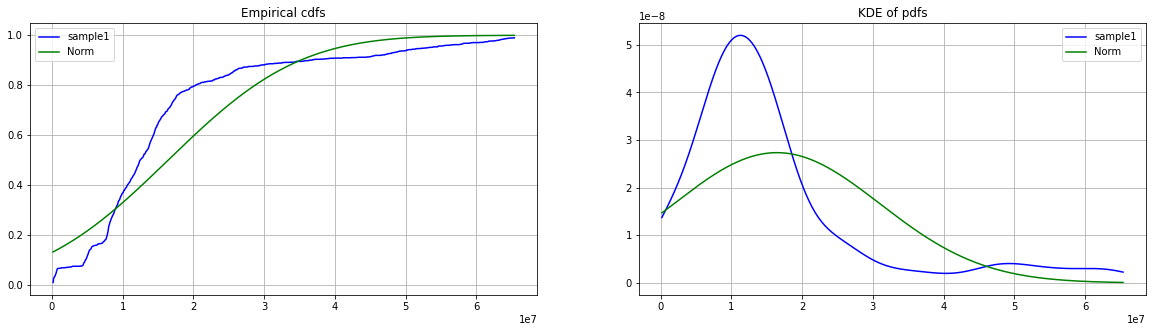

In [36]:
KS_test(TVL_v1['totalLiquidityUSD'], norm)

#Uniswap_v2 TVl

In [37]:
from datetime import datetime
tvls = requests.get('https://api.llama.fi/protocol/uniswap-v2').json()['chainTvls']




TVL_v2 = None
for key in tvls.keys():
    tmp = pd.DataFrame(tvls[key]['tvl'])
    
    if TVL_v2 is None:
        TVL_v2 = tmp
        continue

    TVL_v2 = TVL_v2.merge(tmp, on='date', suffixes=('', key), how='outer')
    
TVL_v2['date'] = TVL_v2.date.apply(lambda x: datetime.utcfromtimestamp(x))

In [38]:
TVL_v2.set_index('date', inplace = True)

In [39]:
TVL_v2

,totalLiquidityUSD
date,
2020-05-06 00:00:00,9.899200e-01
2020-05-07 00:00:00,3.184090e+00
2020-05-08 00:00:00,3.201490e+00
2020-05-09 00:00:00,1.878565e+01
2020-05-10 00:00:00,1.882144e+01
...,...
2022-11-01 00:00:00,1.146900e+09
2022-11-02 00:00:00,1.154377e+09
2022-11-03 00:00:00,1.124921e+09


In [40]:
TVL_v2.describe()

,totalLiquidityUSD
count,9.140000e+02
mean,3.124608e+09
std,2.186138e+09
min,9.899200e-01
25%,1.314463e+09
50%,2.992304e+09
75%,4.714156e+09
max,1.000069e+10


In [41]:
TVL_v2[TVL_v2.index > '2022-01-01'].describe()

,totalLiquidityUSD
count,3.080000e+02
mean,2.129236e+09
std,1.022928e+09
min,1.007916e+09
25%,1.220726e+09
50%,1.649352e+09
75%,3.041599e+09
max,4.759290e+09


In [42]:
px.bar(TVL_v2[TVL_v2.index > '2022-01-01'])

KstestResult(statistic=0.9981798588130292, pvalue=0.0)

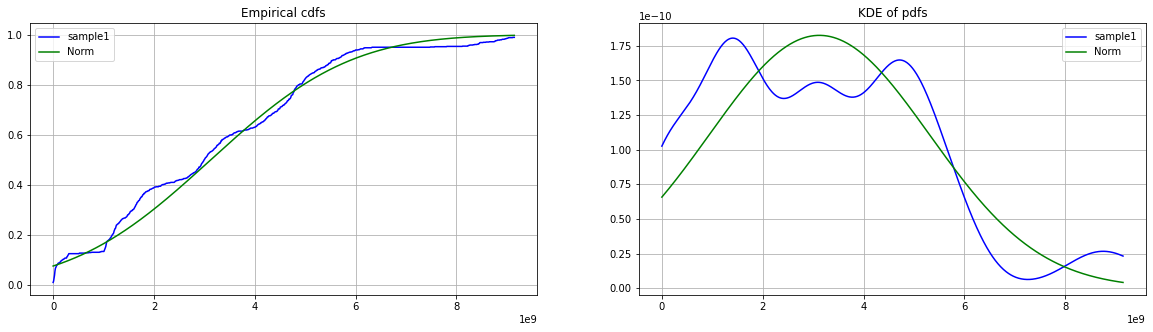

In [43]:
KS_test(TVL_v2['totalLiquidityUSD'], norm)

#Uniswap_V3 TVl

In [44]:
from datetime import datetime
tvls = requests.get('https://api.llama.fi/protocol/uniswap-v3').json()['chainTvls']




TVL_v3 = None
for key in tvls.keys():
    tmp = pd.DataFrame(tvls[key]['tvl'])
    
    if TVL_v3 is None:
        TVL_v3 = tmp
        continue

    TVL_v3 = TVL_v3.merge(tmp, on='date', suffixes=('', key), how='outer')
    
TVL_v3['date'] = TVL_v3.date.apply(lambda x: datetime.utcfromtimestamp(x))

In [45]:
TVL_v3.set_index('date', inplace = True)

In [46]:
TVL_v3

,totalLiquidityUSD,totalLiquidityUSDEthereum,totalLiquidityUSDPolygon,totalLiquidityUSDCelo,totalLiquidityUSDArbitrum
date,,,,,
2021-11-13,3.904444e+07,3.805057e+09,NaN,NaN,6.415418e+07
2021-11-14,3.851921e+07,3.803048e+09,NaN,NaN,6.303078e+07
2021-11-15,3.858285e+07,3.819210e+09,NaN,NaN,6.478571e+07
2021-11-16,3.801042e+07,3.771110e+09,NaN,NaN,6.340158e+07
2021-11-17,3.562659e+07,3.611641e+09,NaN,NaN,5.948667e+07
...,...,...,...,...,...
2021-11-08,NaN,3.624914e+09,NaN,NaN,6.017269e+07
2021-11-09,NaN,3.773584e+09,NaN,NaN,5.929698e+07
2021-11-10,NaN,3.764398e+09,NaN,NaN,5.791270e+07


In [47]:
TVL_v3.describe()

,totalLiquidityUSD,totalLiquidityUSDEthereum,totalLiquidityUSDPolygon,totalLiquidityUSDCelo,totalLiquidityUSDArbitrum
count,3.580000e+02,5.450000e+02,3.200000e+02,1.200000e+02,4.290000e+02
mean,4.127575e+07,3.051766e+09,7.476654e+07,1.089804e+06,6.094828e+07
std,1.014842e+07,8.956262e+08,2.217057e+07,2.305835e+05,1.572642e+07
min,9.627025e+06,1.396867e+08,1.656287e+03,2.772709e+04,1.757643e+06
25%,3.511414e+07,2.583202e+09,6.035294e+07,1.001579e+06,5.365071e+07
50%,4.363949e+07,3.231038e+09,7.474620e+07,1.056888e+06,6.139090e+07
75%,4.891266e+07,3.785547e+09,8.727539e+07,1.246067e+06,7.045452e+07
max,5.785002e+07,4.632199e+09,1.247007e+08,1.605677e+06,9.327423e+07


In [48]:
TVL_v3[TVL_v3.index > '2022-01-01'].describe()

,totalLiquidityUSD,totalLiquidityUSDEthereum,totalLiquidityUSDPolygon,totalLiquidityUSDCelo,totalLiquidityUSDArbitrum
count,3.080000e+02,3.080000e+02,3.080000e+02,1.200000e+02,3.080000e+02
mean,4.250097e+07,3.523535e+09,7.686063e+07,1.089804e+06,6.587371e+07
std,1.036010e+07,4.410631e+08,1.964957e+07,2.305835e+05,1.208215e+07
min,9.627025e+06,2.681425e+09,3.982466e+07,2.772709e+04,3.972767e+07
25%,3.595905e+07,3.135545e+09,6.270287e+07,1.001579e+06,5.766647e+07
50%,4.578612e+07,3.554502e+09,7.515723e+07,1.056888e+06,6.599140e+07
75%,4.941304e+07,3.879753e+09,8.765427e+07,1.246067e+06,7.284164e+07
max,5.785002e+07,4.632199e+09,1.247007e+08,1.605677e+06,9.327423e+07


In [49]:
px.bar(TVL_v3[TVL_v3.index > '2022-01-01'])

KstestResult(statistic=1.0, pvalue=0.0)

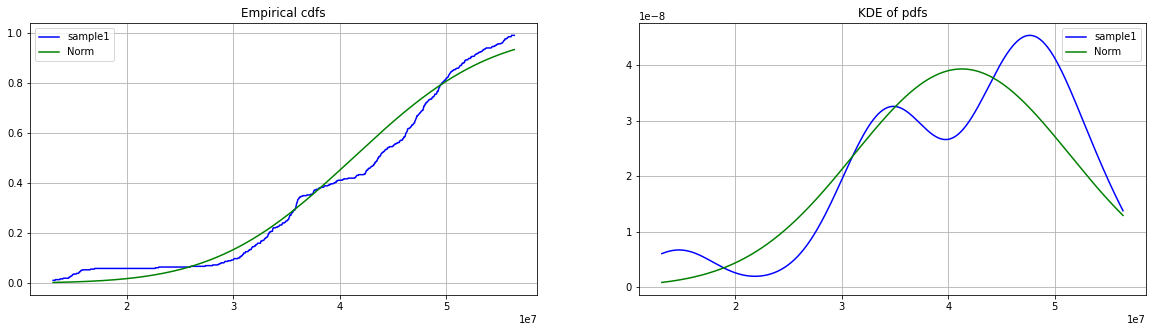

In [50]:
KS_test(TVL_v3['totalLiquidityUSD'].dropna(), norm)

#Uniswap_V3 trading_volumes

In [71]:
request_url = "https://api.coingecko.com/api/v3/exchanges/uniswap_v3/volume_chart?days=1000"
data = requests.get(request_url).json()


In [72]:
uniswap_v3_volume = pd.DataFrame(data, columns = ['date','volumes'])

In [73]:
uniswap_v3_volume['date'] = uniswap_v3_volume.date.apply(lambda x: datetime.utcfromtimestamp(x//1000))
uniswap_v3_volume.set_index('date', inplace = True)

In [74]:
uniswap_v3_volume.volumes = uniswap_v3_volume.volumes.astype(float)

In [75]:
uniswap_v3_volume.describe()

,volumes
count,548.000000
mean,43183.193743
std,39038.292579
min,0.000000
25%,24404.321228
50%,34408.553095
75%,48181.186686
max,358564.136433


In [76]:
uniswap_v3_volume[uniswap_v3_volume.index > '2022-01-01'].describe()

,volumes
count,308.000000
mean,52668.109440
std,45018.100925
min,0.000000
25%,32141.221088
50%,41663.219344
75%,56737.129062
max,358564.136433


In [77]:

px.bar(uniswap_v3_volume[uniswap_v3_volume.index > '2022-01-01'])

KstestResult(statistic=0.9963503649635036, pvalue=0.0)

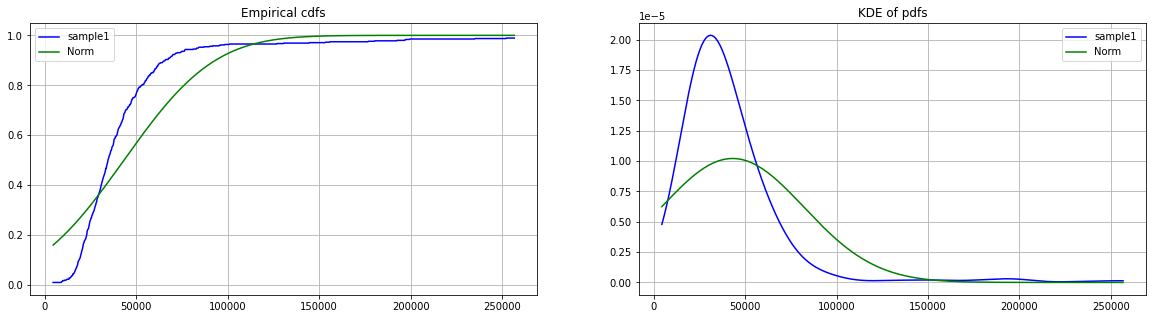

In [79]:
KS_test(uniswap_v3_volume.volumes.dropna(), norm)

#Uniswap_V2 trading_volumes

In [80]:
request_url = "https://api.coingecko.com/api/v3/exchanges/uniswap_v2/volume_chart?days=700"
data = requests.get(request_url).json()


In [81]:
uniswap_v2_volume = pd.DataFrame(data, columns = ['date','volumes'])

In [82]:
uniswap_v2_volume['date'] = uniswap_v2_volume.date.apply(lambda x: datetime.utcfromtimestamp(x//1000))
uniswap_v2_volume.set_index('date', inplace = True)

In [83]:
uniswap_v2_volume.volumes = uniswap_v2_volume.volumes.astype(float)

In [84]:
uniswap_v3_volume.describe()

,volumes
count,548.000000
mean,43183.193743
std,39038.292579
min,0.000000
25%,24404.321228
50%,34408.553095
75%,48181.186686
max,358564.136433


In [85]:
uniswap_v3_volume[uniswap_v3_volume.index > '2022-01-01'].describe()

,volumes
count,308.000000
mean,52668.109440
std,45018.100925
min,0.000000
25%,32141.221088
50%,41663.219344
75%,56737.129062
max,358564.136433


In [86]:
cols = list(df.columns)

px.bar(uniswap_v2_volume[uniswap_v2_volume.index > '2022-01-01'])

KstestResult(statistic=1.0, pvalue=0.0)

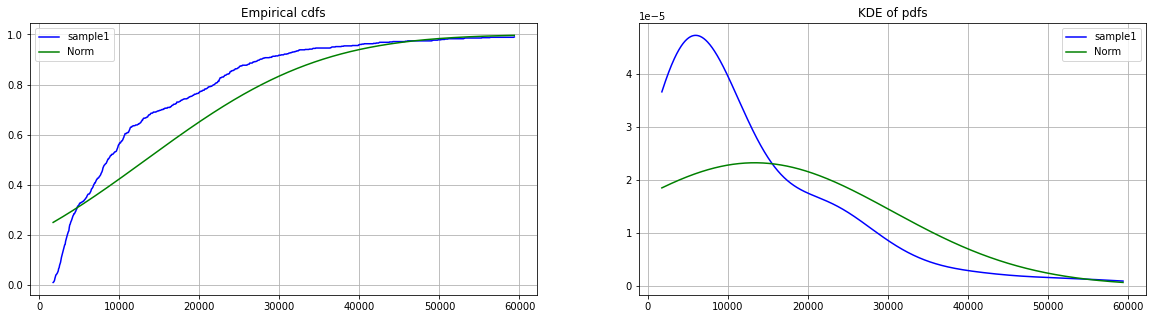

In [87]:
KS_test(uniswap_v2_volume.volumes, norm)